In [69]:
# Importing necessary packages
import cobra
import itertools
import matplotlib.pyplot as plt
import metquest
import networkx as nx
import numpy as np
import orthoani
import os
import palettable
import pandas as pd
import pickle
import re
import shutil
import sys
import tempfile
from Bio.SeqIO import parse
from cobra.medium import minimal_medium
from itertools import combinations
from libsbml import SBMLDocument, SBMLReader
from metquest import create_graph
from typing import Dict, List, Set, Tuple, Union

# Loading necessary path
input_path = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/"

In [17]:
# Collecting all the SBML files
# Collecting the Acinetobacter baumannii AYE (iCN718) and
# Klebsiella pneumoniae subsp. pneumoniae MGH 78578 (iYL1228) models

!wget http://bigg.ucsd.edu/static/models/iCN718.xml -P "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/"
!wget http://bigg.ucsd.edu/static/models/iYL1228.xml -P "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/"

--2024-12-26 17:03:14--  http://bigg.ucsd.edu/static/models/iCN718.xml
Resolving bigg.ucsd.edu (bigg.ucsd.edu)... 169.228.33.117
Connecting to bigg.ucsd.edu (bigg.ucsd.edu)|169.228.33.117|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4921390 (4.7M) [application/xml]
Saving to: ‘/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/iCN718.xml’

iCN718.xml          100%[===================>]   4.69M  1.90MB/s    in 2.5s    

2024-12-26 17:03:18 (1.90 MB/s) - ‘/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/iCN718.xml’ saved [4921390/4921390]

--2024-12-26 17:03:19--  http://bigg.ucsd.edu/static/models/iYL1228.xml
Resolving bigg.ucsd.edu (bigg.ucsd.edu)... 169.228.33.117
Connecting to bigg.ucsd.edu (bigg.ucsd.edu)|169.228.33.117|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9202114 (8.8M) [application/xml]
Saving to: ‘/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/iYL1228.xml’

iYL1228.xml         100%[===================>]   8.78M  2.69MB/s  

In [22]:
# Calculating pairwise average nucleotide identity (ANI)
# Between Acinetobacter baumannii AYE (GCF_000069245.1) 
# and AB6870155 (GCF_000794125.2)
!orthoani -q /mnt/Local_Disk_1/3_MiMB_Book_Chapter/2_Genomes/GCF_000069245.1.fna -r /mnt/Local_Disk_1/3_MiMB_Book_Chapter/2_Genomes/GCF_000794125.2.fna -j 12

# Calculating pairwise average nucleotide identity (ANI)
# Between Klebsiella pneumoniae subsp. pneumoniae MGH 78578 
# (GCF_000016305.1) and KP6870155 (GCF_027126715.1)
!orthoani -q /mnt/Local_Disk_1/3_MiMB_Book_Chapter/2_Genomes/GCF_000016305.1.fna -r /mnt/Local_Disk_1/3_MiMB_Book_Chapter/2_Genomes/GCF_027126715.1.fna -j 12

99.80144101731602
99.0398276003276


In [23]:
# Running MEMOTE on the GEMs
# Model: iCN718
!memote report snapshot --filename "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/3_MEMOTE/iCN718.html" /mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/iCN718.xml

# Model: iYL1228
!memote report snapshot --filename "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/3_MEMOTE/iYL1228.html" /mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/iYL1228.xml

The current solver interface glpk doesn't support setting the optimality tolerance.
============================= test session starts ==============================
platform linux -- Python 3.10.16, pytest-8.3.4, pluggy-1.5.0
rootdir: /home/pratyay/anaconda3/envs/metquest-protocol/lib/python3.10/site-packages/memote/suite/tests
plugins: typeguard-4.4.1, anyio-4.7.0
collected 146 items / 1 skipped                                                

../../../home/pratyay/anaconda3/envs/metquest-protocol/lib/python3.10/site-packages/memote/suite/tests/test_annotation.py . [  0%]
..FFFFFFFFF.FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF.FFFFFFFFFF..         [ 44%]
../../../home/pratyay/anaconda3/envs/metquest-protocol/lib/python3.10/site-packages/memote/suite/tests/test_basic.py . [ 45%]
...F.F........F...F.FF                                                   [ 60%]
../../../home/pratyay/anaconda3/envs/metquest-protocol/lib/python3.10/site-packages/memote/suite/tests/test_biomass.py . [ 60%]
F....F

In [24]:
def validate_SBML(path_to_models: Union[str, os.PathLike]) -> None:
    """
    Validate SBML (Systems Biology Markup Language) files in a specified directory.

    This function reads all `.xml` files in the given directory, checks for errors
    in the SBML structure, and logs whether each file is valid or contains errors.

    Parameters:
        path_to_models (Union[str, os.PathLike]):
            The path to the directory containing SBML `.xml` files to validate.

    Returns:
        None

    Raises:
        FileNotFoundError: If the specified directory does not exist.
        ValueError: If the provided path is not a directory.
    """
    # Ensure the provided path is valid
    if not os.path.exists(path_to_models):
        raise FileNotFoundError(f"The path '{path_to_models}' does not exist.")

    if not os.path.isdir(path_to_models):
        raise ValueError(f"The path '{path_to_models}' is not a directory.")

    # Initialize the SBML reader
    reader = SBMLReader()

    # Iterate through all files in the directory
    for file_name in os.listdir(path_to_models):
        # Process only `.xml` files
        if file_name.endswith('.xml'):
            file_path = os.path.join(path_to_models, file_name)

            try:
                # Read and validate the SBML file
                document: SBMLDocument = reader.readSBML(file_path)

                if document.getNumErrors() > 0:
                    print(f"[ERROR] SBML file '{file_name}' contains errors!")
                    print(document.getErrorLog().toString())
                else:
                    print(f"[SUCCESS] '{file_name}' is a valid SBML file.")

            except Exception as e:
                # Log unexpected errors during processing
                print(f"[EXCEPTION] Failed to process '{file_name}': {e}")

In [25]:
# Validating the SBML files
validate_SBML("/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/")

[SUCCESS] 'iCN718.xml' is a valid SBML file.
[SUCCESS] 'iYL1228.xml' is a valid SBML file.


In [29]:
def min_medium(path_to_models: Union[str, os.PathLike], path_to_medium_file: Union[str, os.PathLike]) -> None:
    """
    Generates the minimal set of metabolites required for multiple organisms to grow
    and saves the output to a text file. If the file does not exist, it will be created.

    Parameters:
        path_to_models (Union[str, os.PathLike]):
            Path to the folder containing the model files in SBML format.
        path_to_medium_file (Union[str, os.PathLike]):
            Path to the output text file where the results will be saved.

    Returns:
        None

    Raises:
        FileNotFoundError: If the specified folder for models does not exist.
        ValueError: If no valid SBML files are found in the provided folder.
    """
    # Ensure the model folder exists
    if not os.path.exists(path_to_models):
        raise FileNotFoundError(f"The path '{path_to_models}' does not exist.")

    if not os.path.isdir(path_to_models):
        raise ValueError(f"The path '{path_to_models}' is not a directory.")

    # Dictionary to store models
    models = {}

    # Load models from the specified folder
    for file_name in os.listdir(path_to_models):
        file_path = os.path.join(path_to_models, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.xml'):
            try:
                # Load the model and add it to the dictionary
                model = cobra.io.read_sbml_model(file_path)
                models[file_name] = model
            except Exception as e:
                print(f"[ERROR] Failed to load model '{file_name}': {e}")

    # Raise an error if no models were successfully loaded
    if not models:
        raise ValueError("No valid SBML models were loaded from the specified folder.")

    # List to store the minimal medium metabolites
    media: List[str] = []

    # Generate minimal medium for each model
    for model_name, model in models.items():
        try:
            # Assume `minimal_medium` is a function that takes a model and returns the minimal medium
            minimal = minimal_medium(model, 0.1, minimize_components=True)
            media += list(minimal.keys())
            print(f"[SUCCESS] Minimal medium calculated for '{model_name}'.")
        except Exception as e:
            print(f"[ERROR] Failed to calculate minimal medium for '{model_name}': {e}")

    # Remove duplicates by converting to a set and back to a list
    media = list(set(media))

    # Check if the output file exists and verify write permissions
    try:
        if os.path.exists(path_to_medium_file):
            if not os.access(path_to_medium_file, os.W_OK):
                raise PermissionError(f"The file '{path_to_medium_file}' exists but is not writable.")
        else:
            parent_dir = os.path.dirname(path_to_medium_file) or "."
            if not os.access(parent_dir, os.W_OK):
                raise PermissionError(f"The directory '{parent_dir}' is not writable.")

        # Write the minimal medium metabolites to the specified file
        with open(path_to_medium_file, "w") as file:
            for item in media:
                file.write(item + "\n")
        print(f"[SUCCESS] Minimal medium metabolites saved to '{path_to_medium_file}'.")
    except PermissionError as pe:
        print(f"[ERROR] Permission issue: {pe}")
    except Exception as e:
        print(f"[ERROR] Failed to save the minimal medium to '{path_to_medium_file}': {e}")

In [50]:
# Calculating the minimal medium
path_to_models = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/" 
path_to_medium_file = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/4_Medium/1_Minimal_medium/curated_minimal_medium.txt" 

min_medium(path_to_models, path_to_medium_file)

[SUCCESS] Minimal medium calculated for 'iCN718.xml'.
[SUCCESS] Minimal medium calculated for 'iYL1228.xml'.
[SUCCESS] Minimal medium metabolites saved to '/mnt/Local_Disk_1/3_MiMB_Book_Chapter/4_Medium/1_Minimal_medium/curated_minimal_medium.txt'.


In [32]:
def get_model_info(model_dir: Union[str, os.PathLike]) -> Tuple[Dict[str, str], Dict[str, List[str]], Dict[str, List[str]], List[str], List[str]]:
    """
    Extracts and returns information about SBML models in a given directory.

    This function provides the following:
    1. `model_id_dict`: A dictionary mapping file names (without .xml extension) to model IDs.
    2. `model_compartments_dict`: A dictionary mapping model IDs to a list of compartments present in the model.
       Example: 'c' for 'cytosol', 'e' for 'extracellular', 'p' for 'periplasm', 'r' for 'endoplasmic reticulum'.
    3. `model_e0_dict`: A dictionary mapping model IDs to lists of reaction IDs containing metabolites ending with "e0".
    4. `model_id_list`: A list of model IDs.
    5. `model_list`: A list of model file names (without .xml extension).

    Parameters:
        model_dir (Union[str, os.PathLike]):
            The path to the directory containing the SBML model files.

    Returns:
        Tuple containing:
            - model_id_dict (Dict[str, str]): File names to model IDs.
            - model_compartments_dict (Dict[str, List[str]]): Model IDs to compartment lists.
            - model_e0_dict (Dict[str, List[str]]): Model IDs to reaction IDs containing "e0" metabolites.
            - model_id_list (List[str]): List of model IDs.
            - model_list (List[str]): List of file names (without .xml extension).

    Raises:
        FileNotFoundError: If the directory does not exist.
        ValueError: If no valid SBML files are found in the directory.
    """
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"The directory '{model_dir}' does not exist.")

    if not os.path.isdir(model_dir):
        raise ValueError(f"The path '{model_dir}' is not a directory.")

    model_id_dict = {}
    model_compartments_dict = {}
    model_e0_dict = {}
    model_id_list = []
    model_list = []

    # Process each file in the directory
    for model_file in os.listdir(model_dir):
        file_path = os.path.join(model_dir, model_file)
        if os.path.isfile(file_path) and model_file.endswith('.xml'):
            try:
                # Load the SBML model
                model = cobra.io.read_sbml_model(file_path)

                # Extract model information
                file_base_name = model_file.replace(".xml", "")
                model_id_dict[file_base_name] = model.id
                model_compartments_dict[model.id] = list(model.compartments.keys())
                model_e0_dict[model.id] = []
                model_id_list.append(model.id)
                model_list.append(file_base_name)

                # Identify reactions containing "e0" metabolites
                for reaction in model.reactions:
                    if not reaction.id.startswith("EX"):
                        if any(metabolite.id.endswith("e0") for metabolite in reaction.metabolites.keys()):
                            model_e0_dict[model.id].append(reaction.id)

            except Exception as e:
                print(f"[ERROR] Failed to process model file '{model_file}': {e}")

    # Ensure at least one valid model was processed
    if not model_id_dict:
        raise ValueError("No valid SBML models were found in the directory.")

    return model_id_dict, model_compartments_dict, model_e0_dict, model_id_list, model_list


In [33]:
# Getting the details of the models
model_id_dict, model_compartments_dict, model_e0_dict, model_id_list, model_list = get_model_info(path_to_models)

print(model_id_list)
print(model_compartments_dict)

['iCN718', 'iYL1228']
{'iCN718': ['c', 'e', 'p', 'r'], 'iYL1228': ['p', 'c', 'e']}


In [34]:
def format_seed(
    seed_dir: Union[str, os.PathLike],
    site_name: str,
    model_compartments_dict: Dict[str, List[str]],
    model_id_list: List[str],
    path_to_seed_metabolites_file: Union[str, os.PathLike]
) -> None:
    """
    Formats the seed metabolites file by adding model IDs and compartments to each metabolite.
    Each metabolite is added to every compartment of each model.

    Parameters:
        seed_dir (Union[str, os.PathLike]):
            Path to the folder containing the seed files (minimal medium file and optionally cofactors file).
        site_name (str):
            The base name of the minimal medium file (without extension).
        model_compartments_dict (Dict[str, List[str]]):
            A dictionary mapping model IDs to lists of compartments.
        model_id_list (List[str]):
            A list of model IDs.
        path_to_seed_metabolites_file (Union[str, os.PathLike]):
            Path to the output file where the formatted seed metabolites will be saved.

    Returns:
        None

    Raises:
        FileNotFoundError: If the minimal medium file does not exist.
        Exception: If an error occurs while reading or writing files.
    """
    try:
        # Read the seed list from the minimal medium file
        seed_file_path = os.path.join(seed_dir, site_name + ".txt")
        if not os.path.isfile(seed_file_path):
            raise FileNotFoundError(f"The minimal medium file '{seed_file_path}' does not exist.")
        
        with open(seed_file_path, "r") as seed_file:
            seed_list = seed_file.read().splitlines()

        # Read the cofactors list if the file exists
        cofactor_file_path = os.path.join(seed_dir, "cofactors.txt")
        cofactor_list = []
        if os.path.isfile(cofactor_file_path):
            with open(cofactor_file_path, "r") as cofactor_file:
                cofactor_list = cofactor_file.read().splitlines()

        # Combine seed and cofactor lists into a total set
        total: Set[str] = set(seed_list).union(set(cofactor_list))

        # Create the formatted seed set
        seed_set: Set[str] = set()
        for model_id in model_id_list:
            compartments = model_compartments_dict.get(model_id, [])
            for compartment in compartments:
                for metabolite in total:
                    formatted_metabolite = f"{model_id} {metabolite}_{compartment}"
                    seed_set.add(formatted_metabolite)

        # Write the formatted seed metabolites to the output file
        with open(path_to_seed_metabolites_file, "w") as output_file:
            for item in sorted(seed_set):
                output_file.write(item + "\n")

        print(f"[SUCCESS] Formatted seed metabolites saved to '{path_to_seed_metabolites_file}'.")

    except FileNotFoundError as fnf_error:
        print(f"[ERROR] {fnf_error}")
    except Exception as e:
        print(f"[ERROR] An error occurred: {e}")

In [67]:
# Formatting the seed metabolites
seed_dir = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/4_Medium/1_Minimal_medium/"
site_name = "curated_minimal_medium"
path_to_seed_metabolites_file= "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/curated_minimal_medium_formatted.txt"

format_seed(seed_dir,site_name,model_compartments_dict,model_id_list,path_to_seed_metabolites_file)

[SUCCESS] Formatted seed metabolites saved to '/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/curated_minimal_medium_formatted.txt'.


In [39]:
# Constants for artifact identifiers
artifacts = [
    "cpd17041",  # Biomass
    "cpd17042",  # DNA replication
    "cpd17043",  # RNA transcription
    "cpd11416"   # Protein biosynthesis
]

def remove_artifacts(
    graph: nx.DiGraph,
    namemap: Dict[str, List[str]],
    model_compartments_dict: Dict[str, List[str]],
    model_id_list: List[str] = []
) -> nx.DiGraph:
    """
    Removes artifact nodes and associated edges from the graph.

    Parameters:
        graph (nx.DiGraph):
            The directed graph representing the metabolic network.
        namemap (Dict[str, List[str]]):
            A mapping of node identifiers to names.
        model_compartments_dict (Dict[str, List[str]]):
            A dictionary mapping model IDs to their compartments.
        model_id_list (List[str], optional):
            A list of model IDs to filter artifacts.

    Returns:
        nx.DiGraph: The modified graph with artifact nodes removed.
    """
    global artifacts
    remove = set()

    # Identify nodes with 'bio1' in their names for removal
    for key, values in namemap.items():
        if "bio1" in values:
            remove.add(key)

    # Create a set of artifact-related nodes
    artifacts_set = set()
    for artifact in artifacts:
        for model_id in model_id_list:
            for compartment in model_compartments_dict.get(model_id, []):
                node = f"{artifact}_{compartment}"
                if graph.has_node(node):
                    artifacts_set.add(node)
                model_node = f"{model_id}_{compartment}"
                if graph.has_node(model_node):
                    artifacts_set.add(f"{model_id} {node}")

    # Add edges connected to artifact nodes for removal
    for artifact_node in artifacts_set:
        for in_edge in graph.out_edges(artifact_node):
            remove.update(in_edge)
        for out_edge in graph.in_edges(artifact_node):
            remove.update(out_edge)

    # Remove identified nodes
    for node in remove:
        if graph.has_node(node):
            graph.remove_node(node)

    return graph

In [40]:
def get_individual_graph(
    model_dir: str, 
    model_id_dict: Dict[str, str], 
    model_compartments_dict: Dict[str, str], 
    model_list: list,
    intermediate_dir: str
) -> Tuple[Dict[str, nx.Graph], Dict[str, Dict]]:
    """
    Create individual graphs for models and save them for later use.

    Parameters:
    ----------
    model_dir : str
        Path to the folder containing the models.
    model_id_dict : Dict[str, str]
        Dictionary mapping model names to their IDs.
    model_compartments_dict : Dict[str, str]
        Dictionary containing compartment details for the models.
    model_list : list
        List of model names to process.
    intermediate_dir : str
        Path to the directory to save intermediate files.

    Returns:
    -------
    None
    """
    print("[INFO] Creating individual graphs...")

    individual_graph_dict = {}
    individual_namemap_dict = {}

    os.makedirs(intermediate_dir, exist_ok=True)

    for model_name in model_list:
        file_path = os.path.join(model_dir, f"{model_name}.xml")
        if file_path.endswith(".xml") and os.path.isfile(file_path):
            # Copy the model file to intermediate directory
            intermediate_file = os.path.join(intermediate_dir, f"{model_name}.xml")
            shutil.copyfile(file_path, intermediate_file)

    # Create graph
    num = 1
    graph, namemap = create_graph(intermediate_dir, num)
    graph = remove_artifacts(
        graph, namemap, model_compartments_dict, [model_id_dict[model_name]]
    )
    
    print(f"[INFO] Saved graph and namemap for all the models in {intermediate_dir}")

    return individual_graph_dict, individual_namemap_dict

In [41]:
# Getting the individual graphs
model_dir = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/"
intermediate_dir = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/"

individual_graph_dict, individual_namemap_dict = get_individual_graph(model_dir, model_id_dict, model_compartments_dict, model_list, intermediate_dir)

[INFO] Creating individual graphs...
Filenames ['iCN718.xml', 'iYL1228.xml']
Number of edges in graph 6194
Number of nodes in graph 2467
Graph and namemap saved for file(s) in /mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/
Number of edges in graph 11214
Number of nodes in graph 5039
Graph and namemap saved for file(s) in /mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/
[INFO] Saved graph and namemap for all the models in /mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/


In [42]:
def get_pair_graph(
    model_dir: str, 
    model_id_dict: Dict[str, str], 
    model_compartments_dict: Dict[str, str], 
    model_list: list,
    intermediate_dir: str
) -> Tuple[Dict[str, nx.Graph], Dict[str, Dict]]:
    """
    Create pairwise graphs for combinations of models and save them for later use.

    Parameters:
    ----------
    model_dir : str
        Path to the folder containing the models.
    model_id_dict : Dict[str, str]
        Dictionary mapping model names to their IDs.
    model_compartments_dict : Dict[str, str]
        Dictionary containing compartment details for the models.
    model_list : list
        List of model names to process.
    intermediate_dir : str
        Path to the directory to save intermediate files.

    Returns:
    -------
    pair_graph_dict : Dict[str, nx.Graph]
        Dictionary of pairwise graphs for each combination of models.
    pair_namemap_dict : Dict[str, Dict]
        Dictionary of name maps for each combination of models.
    """
    print("[INFO] Creating pairwise graphs...")

    pair_graph_dict = {}
    pair_namemap_dict = {}
    done = []

    os.makedirs(intermediate_dir, exist_ok=True)

    combinations_list = combinations(model_list, 2)
    for comb in combinations_list:
        pair_name = f"{comb[0]}_{comb[1]}"
        if pair_name not in done and f"{comb[1]}_{comb[0]}" not in done:
            done.append(pair_name)

            file1 = os.path.join(model_dir, f"{comb[0]}.xml")
            file2 = os.path.join(model_dir, f"{comb[1]}.xml")

            if (file1.endswith(".xml") and os.path.isfile(file1) and
                file2.endswith(".xml") and os.path.isfile(file2)):

                # Copy the model files to intermediate directory
                intermediate_file1 = os.path.join(intermediate_dir, f"{comb[0]}.xml")
                intermediate_file2 = os.path.join(intermediate_dir, f"{comb[1]}.xml")

                shutil.copyfile(file1, intermediate_file1)
                shutil.copyfile(file2, intermediate_file2)

                # Create pairwise graph
                num = 2
                graph, namemap = create_graph(intermediate_dir, num)
                graph = remove_artifacts(
                    graph, namemap, model_compartments_dict, [
                        model_id_dict[comb[0]], model_id_dict[comb[1]]
                    ]
                )

                # Save the graph and namemap
                graph_pickle_path = os.path.join(intermediate_dir, f"{pair_name}_graph.pickle")
                namemap_pickle_path = os.path.join(intermediate_dir, f"{pair_name}_namemap.pickle")

                with open(graph_pickle_path, 'wb') as graph_file:
                    pickle.dump(graph, graph_file, pickle.HIGHEST_PROTOCOL)
                with open(namemap_pickle_path, 'wb') as namemap_file:
                    pickle.dump(namemap, namemap_file, pickle.HIGHEST_PROTOCOL)

                pair_graph_dict[pair_name] = graph
                pair_namemap_dict[pair_name] = namemap

                print(f"[INFO] Saved graph and namemap for pair: {pair_name}")

    return pair_graph_dict, pair_namemap_dict

In [43]:
# Getting the pair graphs
model_dir = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/1_Models/"
intermediate_dir = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/"

pair_graph_dict, pair_namemap_dict = get_pair_graph(model_dir, model_id_dict, model_compartments_dict, model_list, intermediate_dir)

[INFO] Creating pairwise graphs...
Filenames ['iCN718.xml', 'iYL1228.xml']
Number of edges in graph 17408
Number of nodes in graph 7400
Graph and namemap saved for file(s) in /mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/
[INFO] Saved graph and namemap for pair: iCN718_iYL1228


In [58]:
def find_metabolic_support_index(intermediate_dir, graph_name_combined, graph_name_firstorg, graph_name_secondorg, seed_metabolite_fname):
    """
    Calculate the Metabolic Support Index (MSI), which defines the fraction of blocked
    or stuck reactions relieved by the presence of another organism. This index is useful
    for assessing the metabolic support between two organisms within a combined metabolic network.

    Parameters
    ----------
    intermediate_dir : str
        Path to the directory containing all data files (e.g., graphs, metabolites).
    graph_name_combined : str
        Filename of the combined graph (joint metabolic network) between two organisms.
    graph_name_firstorg : str
        Filename of the first organism's graph (metabolic network).
    graph_name_secondorg : str
        Filename of the second organism's graph (metabolic network).
    seed_metabolite_fname : str
        Filename containing the seed metabolite list that will be used to perform the forward pass.

    Returns
    -------
    None
        Outputs MSI values to a CSV file and prints results to the console. The MSI indicates the fraction
        of metabolic reactions that are relieved (stuck reactions are "unblocked") when the two organisms
        are in the same environment.
    """

    # Helper function to load a graph from a pickle file
    def load_pickle_graph(filepath):
        """
        Load a metabolic network graph from a pickle file.

        Parameters
        ----------
        filepath : str
            Path to the pickle file containing the graph.

        Returns
        -------
        networkx.Graph
            Loaded graph object.
        """
        with open(filepath, "rb") as file:
            return pickle.load(file)

    print("[INFO] Loading graph files...")

    # Load the combined and individual organism graphs
    combined_graph = load_pickle_graph(os.path.join(intermediate_dir, graph_name_combined))
    first_org_graph = load_pickle_graph(os.path.join(intermediate_dir, graph_name_firstorg))
    second_org_graph = load_pickle_graph(os.path.join(intermediate_dir, graph_name_secondorg))

    print("[INFO] Loading seed metabolite file...")

    # Load seed metabolites from the provided file
    with open(os.path.join(intermediate_dir, seed_metabolite_fname), "r") as f:
        seed_metabolites = set(f.read().splitlines())

    # Run MetQuest's forward pass to calculate metabolic scope for all graphs
    print("[INFO] Performing metabolic scope calculations for combined and individual graphs...")
    lb_m, status_dict, scope = metquest.forward_pass(combined_graph, seed_metabolites)
    lb_m_org_1, status_dict_org_1, scope_org_1 = metquest.forward_pass(first_org_graph, seed_metabolites)
    lb_m_org_2, status_dict_org_2, scope_org_2 = metquest.forward_pass(second_org_graph, seed_metabolites)

    # Extract reactions and metabolites for both organisms
    def extract_reactions_and_metabolites(graph):
        """
        Extract reaction and metabolite nodes from a metabolic network graph.

        Parameters
        ----------
        graph : networkx.Graph
            The metabolic network graph from which reactions and metabolites are to be extracted.

        Returns
        -------
        reactions : list
            List of reaction nodes.
        metabolites : list
            List of metabolite nodes.
        """
        reactions, metabolites = [], []
        node_attr = nx.get_node_attributes(graph, 'bipartite')
        for node in graph:
            if node_attr[node] == 1:  # Reaction nodes
                reactions.append(node)
            else:  # Metabolite nodes
                met_name = node.split(' ')[0]
                if '_e' not in met_name:  # Exclude extracellular metabolites
                    metabolites.append(met_name)
        return reactions, metabolites

    # Extract reactions and metabolites for both organisms
    org_1_reactions, org_1_metabolites = extract_reactions_and_metabolites(first_org_graph)
    org_2_reactions, org_2_metabolites = extract_reactions_and_metabolites(second_org_graph)

    # Identify organism labels based on metabolite names (first metabolite name)
    org_1 = org_1_metabolites[0]
    org_2 = org_2_metabolites[0]

    print(f"[INFO] Organism 1 identified as: {org_1}")
    print(f"[INFO] Organism 2 identified as: {org_2}")

    # Identify reactions in the combined graph related to each organism
    reactions = []
    org_1_reactions_combined = []
    org_2_reactions_combined = []

    node_attr = nx.get_node_attributes(combined_graph, 'bipartite')
    for node in combined_graph:
        if node_attr[node] == 1:  # Reaction node
            reactions.append(node)
            if org_1 in node:
                org_1_reactions_combined.append(node)
            if org_2 in node:
                org_2_reactions_combined.append(node)

    def classify_reactions(reactions_combined):
        """
        Classify reactions as either internal or external based on specific tags.

        Parameters
        ----------
        reactions_combined : list
            List of reaction nodes from the combined graph.

        Returns
        -------
        internal : list
            List of internal reactions.
        external : list
            List of external reactions.
        """
        internal, external = [], []
        for reaction in reactions_combined:
            if 'ER' not in reaction:  # 'ER' tag for external reactions
                internal.append(reaction)
            else:
                external.append(reaction)
        return internal, external

    # Classify reactions for both organisms in the combined graph
    org_1_internal, org_1_external = classify_reactions(org_1_reactions_combined)
    org_2_internal, org_2_external = classify_reactions(org_2_reactions_combined)

    # Calculate stuck reactions in the combined graph (those not active in the forward pass)
    all_stuck_nodes = set(reactions) - set(status_dict)

    def classify_stuck_reactions(stuck_nodes, organism_label):
        """
        Classify stuck reactions as internal or external based on the organism label.

        Parameters
        ----------
        stuck_nodes : set
            Set of stuck reaction nodes.
        organism_label : str
            Organism label used to filter reactions related to the organism.

        Returns
        -------
        internal : list
            List of internal stuck reactions for the given organism.
        external : set
            Set of external stuck reactions for the given organism.
        """
        internal, external = [], set()
        for node in stuck_nodes:
            if organism_label in node:
                if 'NCE' not in node and 'ER' not in node:
                    if any(tag in node for tag in ['IR', 'RR', 'RevBR']):  # Internal reaction tags
                        internal.append(node)
                else:
                    external.add(node)
        return internal, external

    # Classify stuck reactions for both organisms
    stuck_org_1_internal, stuck_org_1_external = classify_stuck_reactions(all_stuck_nodes, org_1)
    stuck_org_2_internal, stuck_org_2_external = classify_stuck_reactions(all_stuck_nodes, org_2)

    # Calculate individual stuck reactions for each organism
    def identify_stuck_reactions(status_dict, reactions):
        """
        Identify the stuck reactions for a given organism based on the status dictionary.

        Parameters
        ----------
        status_dict : dict
            The status dictionary from MetQuest's forward pass.
        reactions : list
            List of reaction nodes for the organism.

        Returns
        -------
        internal : list
            List of internal stuck reactions for the organism.
        external : list
            List of external stuck reactions for the organism.
        """
        stuck_nodes = set(reactions) - set(status_dict)
        internal, external = [], []
        for node in stuck_nodes:
            if any(tag in node for tag in ['IR', 'RR', 'RevBR']):  # Internal reaction tags
                if 'E' not in node:  # Exclude external reactions
                    internal.append(node)
                else:
                    external.append(node)
            else:
                external.append(node)
        return internal, external

    # Identify individual stuck reactions for each organism
    org_1_stuck_internal, org_1_stuck_external = identify_stuck_reactions(status_dict_org_1, org_1_reactions)
    org_2_stuck_internal, org_2_stuck_external = identify_stuck_reactions(status_dict_org_2, org_2_reactions)

    # Calculate MSI values for both organisms based on internal stuck reactions
    def calculate_msi(stuck_individual, stuck_combined):
        """
        Calculate the Metabolic Support Index (MSI) as the fraction of stuck reactions relieved
        by the combined metabolic environment.

        Parameters
        ----------
        stuck_individual : list
            List of individual stuck reactions.
        stuck_combined : list
            List of combined stuck reactions (when both organisms are present).

        Returns
        -------
        float
            The calculated MSI value.
        """
        return (len(stuck_individual) - len(stuck_combined)) / len(stuck_individual)

    # Calculate MSI for both organisms
    msi_org_1 = calculate_msi(org_1_stuck_internal, stuck_org_1_internal)
    msi_org_2 = calculate_msi(org_2_stuck_internal, stuck_org_2_internal)

    # Print the calculated MSI values
    print("[INFO] Calculating Metabolic Support Index (MSI)...")
    print(f"[INFO] MSI ({org_1} in presence of {org_2}): {msi_org_1:.4f}")
    print(f"[INFO] MSI ({org_2} in presence of {org_1}): {msi_org_2:.4f}")

    # Output MSI to CSV
    output_dir = os.path.join(intermediate_dir, 'results')
    os.makedirs(output_dir, exist_ok=True)
    output_file = org_1 + '_' + org_2 + '_' + seed_metabolite_fname[:-14] + '_MSI.csv'

    msi_output_file = os.path.join(output_dir, output_file)
    with open(msi_output_file, 'w') as f:
        f.write('Organism,In_the_presence_of,MSI_value\n')
        f.write(f"{org_1},{org_2},{msi_org_1:.4f}\n")
        f.write(f"{org_2},{org_1},{msi_org_2:.4f}\n")

    print(f"[SUCCESS] MSI values have been written to: {msi_output_file}")


In [65]:
# Calculating the Metabolic Support Index (MSI)
graph_name_combined = "iCN718_iYL1228_.gpickle"
graph_name_firstorg = "iCN718_.gpickle"
graph_name_secondorg = "iYL1228_.gpickle"
seed_metabolite_fname = "curated_minimal_medium_formatted.txt"

find_metabolic_support_index(intermediate_dir, graph_name_combined, graph_name_firstorg, graph_name_secondorg, seed_metabolite_fname)

[INFO] Loading graph files...
[INFO] Loading seed metabolite file...
[INFO] Performing metabolic scope calculations for combined and individual graphs...
[INFO] Organism 1 identified as: iCN718
[INFO] Organism 2 identified as: iYL1228
[INFO] Calculating Metabolic Support Index (MSI)...
[INFO] MSI (iCN718 in presence of iYL1228): 0.0998
[INFO] MSI (iYL1228 in presence of iCN718): 0.0076
[SUCCESS] MSI values have been written to: /mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/results/iCN718_iYL1228_curated_minimal_medium_MSI.csv


In [64]:
# Iteratively for other medium files
# Formatting M9 medium
seed_dir = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/4_Medium/2_M9_medium/"
site_name = "M9_medium"
path_to_seed_metabolites_file= "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/M9_medium_formatted.txt"

format_seed(seed_dir,site_name,model_compartments_dict,model_id_list,path_to_seed_metabolites_file)

# Formatting LB medium (aerobic)
seed_dir = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/4_Medium/"
site_name = "LB_aerobic"
path_to_seed_metabolites_file= "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/LB_aerobic_formatted.txt"

format_seed(seed_dir,site_name,model_compartments_dict,model_id_list,path_to_seed_metabolites_file)

# Formatting LB medium (anaerobic)
seed_dir = "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/4_Medium/"
site_name = "LB_anaerobic"
path_to_seed_metabolites_file= "/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/LB_anaerobic_formatted.txt"

format_seed(seed_dir,site_name,model_compartments_dict,model_id_list,path_to_seed_metabolites_file)

[SUCCESS] Formatted seed metabolites saved to '/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/M9_medium_formatted.txt'.
[SUCCESS] Formatted seed metabolites saved to '/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/LB_aerobic_formatted.txt'.
[SUCCESS] Formatted seed metabolites saved to '/mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/LB_anaerobic_formatted.txt'.


In [66]:
# Calculating the Metabolic Support Index (MSI) for M9 medium
seed_metabolite_fname = "M9_medium_formatted.txt"

find_metabolic_support_index(intermediate_dir, graph_name_combined, graph_name_firstorg, graph_name_secondorg, seed_metabolite_fname)

# Calculating the Metabolic Support Index (MSI) for LB medium (aerobic)
seed_metabolite_fname = "LB_aerobic_formatted.txt"

find_metabolic_support_index(intermediate_dir, graph_name_combined, graph_name_firstorg, graph_name_secondorg, seed_metabolite_fname)

# Calculating the Metabolic Support Index (MSI) for LB medium (anaerobic)
seed_metabolite_fname = "LB_anaerobic_formatted.txt"

find_metabolic_support_index(intermediate_dir, graph_name_combined, graph_name_firstorg, graph_name_secondorg, seed_metabolite_fname)

[INFO] Loading graph files...
[INFO] Loading seed metabolite file...
[INFO] Performing metabolic scope calculations for combined and individual graphs...
[INFO] Organism 1 identified as: iCN718
[INFO] Organism 2 identified as: iYL1228
[INFO] Calculating Metabolic Support Index (MSI)...
[INFO] MSI (iCN718 in presence of iYL1228): 0.1101
[INFO] MSI (iYL1228 in presence of iCN718): 0.0079
[SUCCESS] MSI values have been written to: /mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir/results/iCN718_iYL1228_M9_medium_MSI.csv
[INFO] Loading graph files...
[INFO] Loading seed metabolite file...
[INFO] Performing metabolic scope calculations for combined and individual graphs...
[INFO] Organism 1 identified as: iCN718
[INFO] Organism 2 identified as: iYL1228
[INFO] Calculating Metabolic Support Index (MSI)...
[INFO] MSI (iCN718 in presence of iYL1228): 0.0110
[INFO] MSI (iYL1228 in presence of iCN718): 0.0019
[SUCCESS] MSI values have been written to: /mnt/Local_Disk_1/3_MiMB_Book_Chapter/5_Int_dir

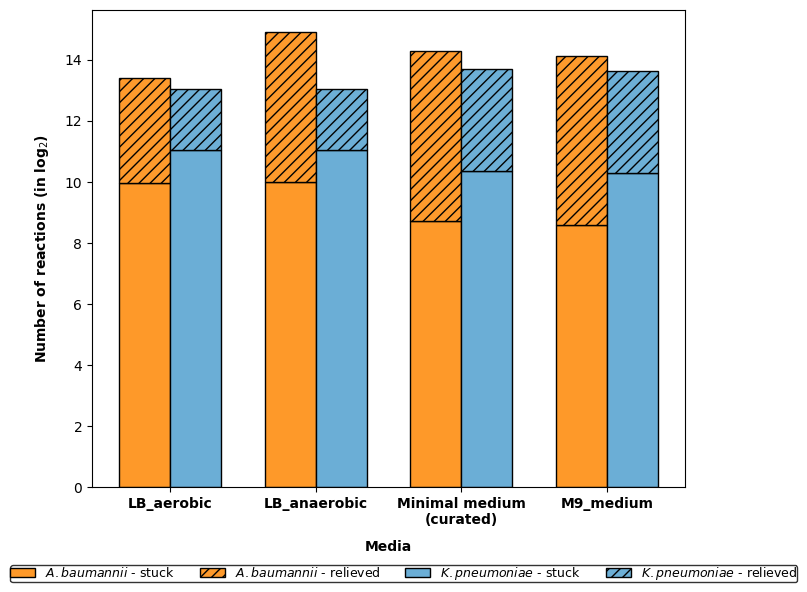

In [116]:
# Plotting the stuck and relieved reactions in individual and paired graphs

# Media conditions for comparison
media = ["LB_aerobic", "LB_anaerobic", "Minimal medium\n(curated)", "M9_medium"]

# Log2 values of the number of reactions
# A. baumannii: 
A_baumannii_main = [9.948367232, 9.981567282, 8.727920455, 8.569855608]
A_baumannii_other = [3.459431619, 4.906890596, 5.554588852, 5.554588852]

# K. pneumoniae: 
K_pneumoniae_main = [11.02859678, 11.033423, 10.3553511, 10.2911707]
K_pneumoniae_other = [2, 2, 3.321928095, 3.321928095]

# Defining color palettes 
yellow_palette = palettable.colorbrewer.sequential.YlOrBr_9.mpl_colors  
blue_palette = palettable.colorbrewer.sequential.Blues_9.mpl_colors  

# Bar width and positions
bar_width = 0.35  
x = np.arange(len(media))  

fig, ax = plt.subplots(figsize=(8, 6))

# Plotting stacked bars for A. baumannii
ax.bar(x - bar_width / 2, A_baumannii_main, width=bar_width, label='$\mathit{A.baumannii}$ - stuck', color=yellow_palette[4], edgecolor='black') 
ax.bar(x - bar_width / 2, A_baumannii_other, width=bar_width, bottom=A_baumannii_main, label='$\mathit{A.baumannii}$ - relieved', color=yellow_palette[4], hatch='///', alpha=0.99, edgecolor='black')

# Plotting stacked bars for K. pneumoniae
ax.bar(x + bar_width / 2, K_pneumoniae_main, width=bar_width, label='$\mathit{K.pneumoniae}$ - stuck', color=blue_palette[4], edgecolor='black')
ax.bar(x + bar_width / 2, K_pneumoniae_other, width=bar_width, bottom=K_pneumoniae_main, label='$\mathit{K.pneumoniae}$ - relieved', color=blue_palette[4], hatch='///', alpha=0.99, edgecolor='black')

ax.set_xlabel('Media', labelpad=9, fontweight="bold")  
ax.set_ylabel('Number of reactions (in log$_2$)', labelpad=10, fontweight="bold")  
ax.set_xticks(x)
ax.set_xticklabels(media, fontsize=10, fontweight="bold")    

# Adding legend
legend = ax.legend(  
    loc='upper right',  
    bbox_to_anchor=(1.2, -0.15),  
    fontsize=9,  
    frameon=True,  
    borderpad=0, ncol=4,
    edgecolor='black' 
)

legend.get_title().set_fontweight('bold')
plt.tight_layout()

# Saving the plot
plt.savefig("/mnt/Local_Disk_1/3_MiMB_Book_Chapter/6_Figures/1_Figure.pdf", format="pdf")
plt.show()

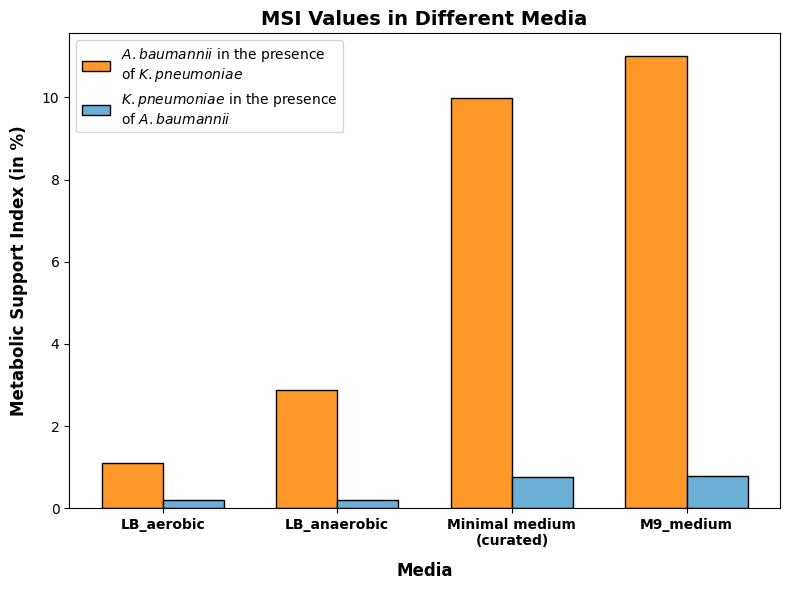

In [115]:
# Plotting the Metabolic Support Index (MSI) values

# Data representing Metabolic Support Index (MSI) values in various media
categories = ["LB_aerobic", "LB_anaerobic", "Minimal medium\n(curated)", "M9_medium"] 

A_baumannii = [1.10, 2.88, 9.98, 11.01]
K_pneumoniae = [0.19, 0.19, 0.76, 0.79]

# Defining color palettes
yellow_palette = palettable.colorbrewer.sequential.YlOrBr_9.mpl_colors  
blue_palette = palettable.colorbrewer.sequential.Blues_9.mpl_colors

# Defining bar positions for the x-axis
x = np.arange(len(categories))  
width = 0.35 
fig, ax = plt.subplots(figsize=(8, 6)) 

# Plotting MSI values for A. baumannii
bar1 = ax.bar(
    x - width/2, A_baumannii, width, 
    label=r'$\mathit{A.baumannii}$ in the presence''\n' 'of $\mathit{K.pneumoniae}$',  
    color=yellow_palette[4], edgecolor='black'
)

# Plotting MSI values for K. pneumoniae 
bar2 = ax.bar(
    x + width/2, K_pneumoniae, width,  
    label=r'$\mathit{K.pneumoniae}$ in the presence''\n' 'of $\mathit{A.baumannii}$',  
    color=blue_palette[4], edgecolor='black'
)

# Adding labels and titles
plt.xlabel("Media", fontsize=12, labelpad=10, fontweight="bold") 
plt.ylabel("Metabolic Support Index (in %)", fontsize=12, labelpad=10, fontweight="bold")  
plt.title("MSI Values in Different Media", fontsize=14, fontweight="bold")  
plt.xticks(x, categories, rotation=0, ha="center")  
ax.set_xticklabels(media, fontsize=10, fontweight="bold")  

# Adding a legend
legend = ax.legend(  
    fontsize=9,  
    frameon=True,  
    borderpad=0, ncol=4,
    labelcolor='black',
)

plt.legend()  
plt.tight_layout()

# Save or display the plot
plt.savefig("/mnt/Local_Disk_1/3_MiMB_Book_Chapter/6_Figures/2_Figure.pdf", format="pdf")
plt.show()  